# KushNet for image classification
This notebook describes KushNet, a convolutional neural network that is used to classify a set of traffic sign images. KushNet was developed as a project for the Udacity Self Driving Car Nano Degree. 

Some statistics for this convnet:

**Image Size**           : 32x32x3

**Original Train Data**  : 34799 samples

**Augmented Train Data** : 191754 samples

**Validation Data**      : 4410 samples

**Test Data**            : 12630 samples

**Training Accuracy**    : 99.07%

**Test Accuracy**        : 95.57%

**Data set**             : [German traffic sign](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) 

### Review of German Traffic Sign dataset

To begin creating a classification network, first, let's familiarise ourselves with the data. To do that, the data needs to be loaded first. This done via the `load_pickled_data` function that generates a set of (x, Y) data sets for training, testing and validation. X and Y are tensorflow Tensors of shape

`X: (?,32,32,3)`

`Y: (?,)`

The `?` denotes that this dimension will be resized when the model is run. 

In [10]:
import pickle

def load_pickled_data(training_file,\
                      validation_file,\
                      testing_file,\
                      verbose=False):
    print()
    print("KushNet 2017")
    print("=================")
    print()
    print("Loading data from:")
    print()
    # Load pickled data
    if (training_file is not None):
        print("Training data file  : {}".format(training_file))
        with open(training_file, mode='rb') as f:
            train = pickle.load(f)
            X_train, y_train = train['features'], train['labels']
        print("Training samples    : {}".format(len(X_train)))
        print("Training data size  : {}".format(X_train[0].shape))
        print()
        assert(len(X_train) == len(y_train))
    else:
        X_train = None
        y_train = None
    if (validation_file is not None):
        print("Validation data file: {}".format(validation_file))
        with open(validation_file, mode='rb') as f:
            valid = pickle.load(f)
            X_valid, y_valid = valid['features'], valid['labels']
        print("Validation samples  : {}".format(len(X_valid)))
        print("Validation data size: {}".format(X_valid[0].shape))
        print()
        assert(len(X_valid) == len(y_valid))
    else:
        X_valid = None
        y_valid = None
    if (testing_file is not None):
        print("Test data file      : {}".format(testing_file))
        with open(testing_file, mode='rb') as f:
            test = pickle.load(f)
            X_test, y_test = test['features'], test['labels']
        print("Test samples        : {}".format(len(X_test)))
        print("Test data size      : {}".format(X_test[0].shape))
        assert(len(X_test) == len(y_test))
    else:
        X_test = None
        y_test = None

    return X_train, y_train, X_test, y_test, X_valid, y_valid

Next, define a dictionary that contains all the labelled data descriptions. This data is found in the "signnames.csv" file included with the datatset.

In [11]:
labels_dict = {
          '0':'Speed limit (20km/h)',
          '1':'Speed limit (30km/h)',
          '2':'Speed limit (50km/h)',
          '3':'Speed limit (60km/h)',
          '4':'Speed limit (70km/h)',
          '5':'Speed limit (80km/h)',
          '6':'End of speed limit (80km/h)',
          '7':'Speed limit (100km/h)',
          '8':'Speed limit (120km/h)',
          '9':'No passing',
          '10':'No passing for vehicles over 3.5 metric tons',
          '11':'Right-of-way at the next intersection',
          '12':'Priority road',
          '13':'Yield',
          '14':'Stop',
          '15':'No vehicles',
          '16':'Vehicles over 3.5 metric tons prohibited',
          '17':'No entry',
          '18':'General caution',
          '19':'Dangerous curve to the left',
          '20':'Dangerous curve to the right',
          '21':'Double curve',
          '22':'Bumpy road',
          '23':'Slippery road',
          '24':'Road narrows on the right',
          '25':'Road work',
          '26':'Traffic signals',
          '27':'Pedestrians',
          '28':'Children crossing',
          '29':'Bicycles crossing',
          '30':'Beware of ice/snow',
          '31':'Wild animals crossing',
          '32':'End of all speed and passing limits',
          '33':'Turn right ahead',
          '34':'Turn left ahead',
          '35':'Ahead only',
          '36':'Go straight or right',
          '37':'Go straight or left',
          '38':'Keep right',
          '39':'Keep left',
          '40':'Roundabout mandatory',
          '41':'End of no passing',
          '42':'End of no passing by vehicles over 3.5 metric tons'}

Next, we'll examine the data. First, let's simply look at the images of 5 random classes


KushNet 2017

Loading data from:

Training data file  : train.p
Training samples    : 34799
Training data size  : (32, 32, 3)



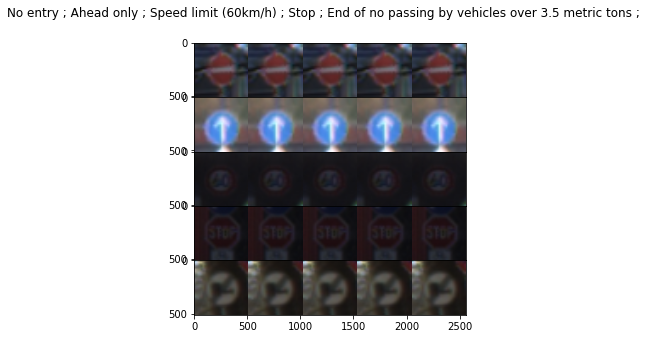

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
import numpy as np

tr_file = 'train.p'

def show_images(X, Y, num):
    fig = plt.figure(1, figsize=(5,5), frameon=False)
    grid = ImageGrid(fig, 111, \
                     nrows_ncols=(len(num),1),\
                     axes_pad=0.0)
    fig_title = ''
    num_columns = min(len(X),5)
    for idx in range(len(num)):
        concat = np.zeros((256,256,3))
        for i in range(num_columns):
            for j in range(len(Y)):
                if(Y[j]==num[idx]):
                    temp = cv2.resize(X[j],None,fx=16,fy=16)
                    if ( i == 0 ):
                        concat = temp
                    else:
                        concat = np.concatenate((concat,temp),axis=1)
                    break
                    #grid[i].imshow(temp)                    
            #print(concat.shape)
        grid[idx].imshow(concat)
        fig_title += labels_dict[str(num[idx])] + ' ; '
    fig.suptitle(fig_title)
    plt.axis('off')
    plt.show()

X_tr, Y_tr, \
dummy0, dummy1, \
dummy2, dummy4 = load_pickled_data(tr_file,None,None)
show_images(X_tr, Y_tr, [17,35,3,14,42])

As can be seen there is significant difference between images of different classes in terms of brightness, contrast, sharpness etc. At this point, the data could be pre-processed to normalize them. 

## Pre-processing the data

Several types of pre-processing were tried for this dataset. The ones that are retained were the ones that showed a significant improvement in validation accuracy

* **Using different colorspaces**: The original dataset consists of RGB images. The image colorspace can be changed to investigate the effect of colorspaces on learning. For this, RGB, HSV and Grayscale colorspaces were used. However, there was no significant difference noted between RGB and HSV/Grayscale. 

* **Histogram equalization**: Histogram equalization is used as a way to normalize the input images. Histograma equalization bumps up the validation accuracy for KushNet. This was used only for RGB images

* **Mean shift**: Subtracting the mean of the image from each pixel in the image was also tried as a means to normalize the input data. This did not significantly affect the overall validation accuracy

In [13]:
def pre_process_data(X_tr,X_va,X_te,color='RGB',show=False):
    
    if ( color == 'RGB' ):
        for i in range(len(X_tr)):
            img_yuv = cv2.cvtColor(X_tr[i], cv2.COLOR_RGB2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            X_tr[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        for i in range(len(X_va)):
            img_yuv = cv2.cvtColor(X_va[i], cv2.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            X_va[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        for i in range(len(X_te)):
            img_yuv = cv2.cvtColor(X_te[i], cv2.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            X_te[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        return X_tr, X_va, X_te
    elif ( color == 'HSV' ):
        for i in range(len(X_tr)):
            X_tr[i] = cv2.cvtColor(X_tr[i],cv2.COLOR_RGB2HSV)
            X_tr[i] -= (np.mean(X_tr[i], axis=0, dtype=np.uint8))
        for i in range(len(X_va)):
            X_va[i] = cv2.cvtColor(X_va[i],cv2.COLOR_RGB2HSV)
            X_va[i] -= (np.mean(X_va[i], axis=0, dtype=np.uint8))
        for i in range(len(X_te)):
            X_te[i] = cv2.cvtColor(X_te[i],cv2.COLOR_RGB2HSV)
            X_te[i] -= (np.mean(X_te[i], axis=0, dtype=np.uint8))
        return X_tr, X_va, X_te
    elif ( color == 'GRY' ):
        X_tr_g = np.zeros((len(X_tr),X_tr.shape[1],X_tr.shape[2]))
        X_va_g = np.zeros((len(X_va),X_va.shape[1],X_va.shape[2]))
        X_te_g = np.zeros((len(X_te),X_te.shape[1],X_te.shape[2]))
        for i in range(len(X_tr)):
            X_tr_g[i] = cv2.cvtColor(X_tr[i],cv2.COLOR_RGB2GRAY)
            X_tr_g[i] -= np.mean(X_tr_g[i], axis=0)
        for i in range(len(X_va)):
            X_va_g[i] = cv2.cvtColor(X_va[i],cv2.COLOR_RGB2GRAY)
            X_va_g[i] -= np.mean(X_va_g[i], axis=0)
        for i in range(len(X_te)):
            X_te_g[i] = cv2.cvtColor(X_te[i],cv2.COLOR_RGB2GRAY)
            X_te_g -= np.mean(X_te_g[i], axis=0)
        return X_tr_g, X_va_g, X_te_g


![alt text](hist_equal_compare.png "RGB -> Preprocessed RGB")

Next, we can try and visualize the distribution of data in the training set using a histogram plot

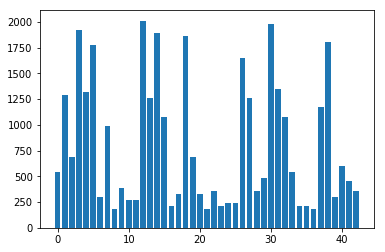

In [14]:
def training_data_distribution(Y_tr):
    data_dict = {}
    for i in range(len(Y_tr)):
        if (str(Y_tr[i]) in list(data_dict.keys())):
            data_dict[str(Y_tr[i])] += 1
        else:
            data_dict[str(Y_tr[i])] = 1
    x = np.arange(len(data_dict))
    fig, ax = plt.subplots()
    bar = ax.bar(x, data_dict.values())
    plt.show()

training_data_distribution(Y_tr)


The plot above shows that the data is not very uniformly distributed. The data can be augmented to make the training set more uniform, this is done before training the network in KushNet.

### Data augmentation

A quick and easy way of improving the network's accuracy is by increasing the training data set[1]. One way to do this quickly is by flipping or rotating the existing data set to generate more data. For this dataset, the following three types of augmentation were used:
* Flip horizontal: Images that can be mirrored horizontally about the middle of the image were used
* Flip vertical: Images that can be mirrored vertically about the middle of the image were used
* Flip vertical and replace: Images that can be mirrored vertically but then belong to a different class were used here. An example of this is a turn right sign; when this sign is flipped about a vertical axis, it becomes a turn left sign and the label is updated ![alt text](turn_compare.png "KushNet")

In [15]:
import sys

def drawProgressBar(percent, barLen = 20, text=""):
    sys.stdout.write("\r")
    progress = ""
    for i in range(barLen):
        if i < int(barLen * percent):
            progress += "="
        else:
            progress += " "
    msg = text + "[ %s ] %.2f%%" % (progress, percent * 100)
    sys.stdout.write(msg)
    sys.stdout.flush()

def add_augmented_data_flip(ids, X, Y,dir='vertical',pairs=False):
    x_flipped = []
    y_flipped = []
    if (pairs == False):
        for i in range(len(Y)):
            drawProgressBar(float((i+1)/len(Y)),20,"Flipping... \t")
            if(Y[i] in ids):
                temp = X[i]
                if (dir=='horizontal'):
                    temp = np.flipud(temp)
                else:
                    temp = np.fliplr(temp)            
                x_flipped.append(temp)
                y_flipped.append(Y[i])
        drawProgressBar(1.0,20,"Flipping... \t")
    else:
        list_a = [item[0] for item in ids]
        list_b = [item[1] for item in ids]
        for i in range(len(Y)):
            drawProgressBar(float((i+1)/len(Y)),20,"Flipping... \t")
            for j in range(len(list_a)):
                if(Y[i]==list_a[j]):
                    temp = X[i]
                    temp = np.fliplr(temp)
                    x_flipped.append(temp)
                    y_flipped.append(list_b[j])
                elif(Y[i]==list_b[j]):
                    temp = X[i]
                    temp = np.fliplr(temp)
                    x_flipped.append(temp)
                    y_flipped.append(list_a[j])
        drawProgressBar(1.0,20,"Flipping... \t")
    X_aug = np.array(x_flipped)
    Y_aug = np.array(y_flipped)
    return X_aug, Y_aug

* Rotate images by a few degrees to obtain new images that are slighlty perturbed from the original. 

In [16]:
import scipy.ndimage

def rotate_image(img, angle):
    return scipy.ndimage.interpolation.rotate(img,angle,reshape=False,mode='reflect')

def add_augmented_data_rotate(X, Y, angle):
    x_rot = []
    y_rot = []
    total = len(angle)*len(X)
    count = 1
    for angle_ in angle:
        for i in range(len(X)):
            drawProgressBar(float(((count-1)*len(X) + (i+1))/total),20,"Rotating... \t")
            x_rot.append(rotate_image(X[i],angle_))
            y_rot.append(Y[i])
        count += 1
    drawProgressBar(1.0,20,"Rotating... \t")
    X_aug = np.array(x_rot)
    Y_aug = np.array(y_rot)
    return X_aug, Y_aug

def augment_data(X_tr,Y_tr,save):
    flip_vertical = [9,11,12,13,15,17,18,22,26,30,35]
    flip_hori = [12,15]
    flip_vertical_pairs = [(19,20), (33,34), (36,37), (38,39)]
    print("Augmenting data...")
    X_aug1, Y_aug1 = add_augmented_data_flip(flip_vertical, X_tr, Y_tr,'vertical')
    print()
    X_aug2, Y_aug2 = add_augmented_data_flip(flip_hori, X_tr, Y_tr,'horizontal')
    print()
    X_aug3, Y_aug3 = add_augmented_data_flip(flip_vertical_pairs, X_tr, Y_tr,'vertical',pairs=True)
    print()
    X_aug4, Y_aug4 = add_augmented_data_rotate(X_tr,Y_tr,[10,10,-5,-10])
    print()
    print("Augmented data size : {}".format(len(X_aug1)+len(X_aug2)+len(X_aug3)+len(X_aug4)))

    X_tr = np.concatenate((np.concatenate((np.concatenate((np.concatenate((X_tr,X_aug1),axis=0),X_aug2),axis=0),X_aug3),axis=0),X_aug4),axis=0)
    Y_tr = np.concatenate((np.concatenate((np.concatenate((np.concatenate((Y_tr,Y_aug1),axis=0),Y_aug2),axis=0),Y_aug3),axis=0),Y_aug4),axis=0)
    
    output = open(save,'wb')
    train_data = {'features':X_tr, 'labels': Y_tr}
    pickle.dump(train_data,output)
    output.close()
    print("\nAugmented data added to training data and saved at {}".format(save))
    return X_tr, Y_tr

To see what rotated images look like, lets rotate an image using this function:

Rotating... 	[ ==================== ] 100.00%

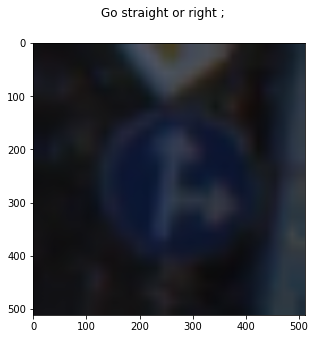

Rotating... 	[ ==================== ] 100.00%

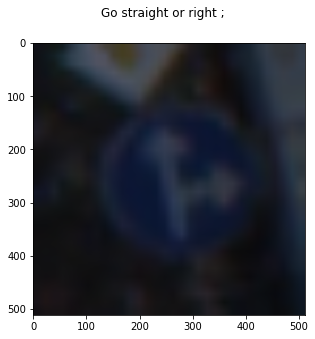

In [17]:
x = [X_tr[1000]]
y = [Y_tr[1000]]
x_rot, y_rot = add_augmented_data_rotate(x,y,[-10])
show_images(x_rot,y_rot,[y[0]])
x_rot, y_rot = add_augmented_data_rotate(x,y,[10])
show_images(x_rot,y_rot,[y[0]])

Lets see what the data augmentation did to the data distribution. The rotation augmentation takes a while to finish. In the interest of time, the augmented data was appended to the training data and saved to disk at `'train_aug.p'` using `pickle`. We can load this data to see what the new distribution looks like


KushNet 2017

Loading data from:

Training data file  : train_aug.p
Training samples    : 191754
Training data size  : (32, 32, 3)



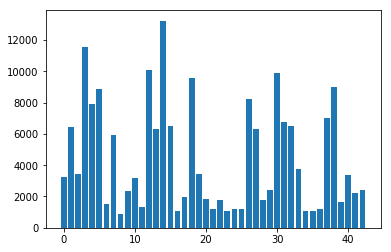

In [18]:
X_tr, Y_tr, \
dummy0, dummy1, \
dummy2, dummy3 = load_pickled_data('train_aug.p',None,None)
training_data_distribution(Y_tr)

The distribution is more or less the same as before with the difference that there are some new outliers in this data.

## Balancing the dataset

To balance the dataset, rotations of 3 and -3 degrees are applied to all images within a class that have less than 2000 images/labels. Balancing helps remove bias that the network may learn based on the frequency of a class in the dataset

In [19]:
def balance_data_rotate(X,Y):
    data_dict = {}
    x_list = []
    y_list = []
    angle = [-3, 3]
    
    for i in range(len(Y)):
        if (str(Y[i]) in list(data_dict.keys())):
            data_dict[str(Y[i])] += 1
        else:
            data_dict[str(Y[i])] = 1
    
    for key in data_dict:
        if ( data_dict[key] < 2000 ):
            for i in range(len(X)):
                if (Y[i] == int(key)):
                    x_list.append(X[i])
                    y_list.append(Y[i])
    
    total = len(angle)*len(x_list)   
    count = 1
    x_rot = []
    y_rot = []
    for angle_ in angle:
        for i in range(len(x_list)):
            drawProgressBar(float(((count-1)*len(x_list) + (i+1))/total),20,"Balancing... \t")
            x_rot.append(rotate_image(x_list[i],angle_))
            y_rot.append(y_list[i])
        count += 1
    drawProgressBar(1.0,20,"Balancing... \t")
    X_aug = np.array(x_rot)
    Y_aug = np.array(y_rot)
    X_tr = np.concatenate((X,X_aug),axis=0)
    Y_tr = np.concatenate((Y,Y_aug),axis=0)
    
    return X_tr, Y_tr

### Kushnet: Network architecture

KushNet is derived off of architecture from the LeNet. The Kushnet has the following main architecture:

![alt text](KushNet_descr.png "KushNet")
1. Input layer (32 x 32 x 3) images. No pre-processing is done in this network
2. 3 Convolution layers, each followed by a RELU activation unit
3. A maxpooling layer
4. 3 Convolution layers, each followed by a RELU activation unit. 
5. A maxpooling layer
6. 2 Fully Connected layers each with ELU activation and dropout
7. Final Fully Connected layer without ELU or dropout

Padding is set to `'VALID'` and `stride` is set to 1 here for all the convolution layers. For the maxpool layers, both `stride` and `kernel size` is set to 2. This is to downsample the stream data. 

The network contains a total of 6 convolution layers and the idea is that the feature maps generated by these layers are able to capture different features of the training data. More depth has been seen to be beneficial to learning, though a very large depth with this architecture was found to either consume too much GPU memory to proceed or require more hyper-parameter tuning. 

Dropout was added to prevent the model from overfitting when tuning the architecture. Dropout is set at 50% and this helps the validation and training error decrease at the same rate thereby preventing overfitting. 

The weights are randomly initialized with a non-zero standard deviation to allow for variance in the initialization of the network.

In [20]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def KushNet2(x, dropout, in_depth, hl_depth):    
    # List of all the weights for L2 norm regularization
    wt_list = []
    save_dict = {}
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32xin_depth. Output = 30x30xhl_depth.
    #          Activation: RELU
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, in_depth, hl_depth), mean = mu, stddev = sigma))
    wt_list.append(conv1_W)
    conv1_b = tf.Variable(tf.zeros(hl_depth))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1   = tf.nn.relu(conv1)
    
    # Layer 2: Convolutional. Input = 30x30xhl_depth. Output = 28x28xhl_depth
    #          Activation: RELU   
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, hl_depth, hl_depth), mean = mu, stddev = sigma))
    wt_list.append(conv2_W)
    conv2_b = tf.Variable(tf.zeros(hl_depth))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2   = tf.nn.relu(conv2)
    
    # Layer 3: Convolutional. Input = 28x28xhl_depth. Output = 26x26xhl_depth
    #          Activation: ELU   
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, hl_depth, hl_depth), mean = mu, stddev = sigma))
    wt_list.append(conv3_W)
    conv3_b = tf.Variable(tf.zeros(hl_depth))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3   = tf.nn.relu(conv3)
    
    # Pooling. Input = 26x26xhl_depth. Output = 12x12xhl_depth.
    pool1 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 4: Convolutional. Input = 12x12xhl_depth. Output = 10x10xhl_depth. 
    #          Activation: ELU   
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, hl_depth, hl_depth), mean = mu, stddev = sigma))
    wt_list.append(conv4_W)
    conv4_b = tf.Variable(tf.zeros(hl_depth))
    conv4   = tf.nn.conv2d(pool1, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    conv4   = tf.nn.relu(conv4)
    
    # Layer 5: Convolutional. Input = 10x10xhl_depth. Output = 8x8xhl_depth 
    #          Activation: ELU   
    conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, hl_depth, hl_depth), mean = mu, stddev = sigma))
    wt_list.append(conv5_W)
    conv5_b = tf.Variable(tf.zeros(hl_depth))
    conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='VALID') + conv5_b
    conv5   = tf.nn.relu(conv5)
    
    # Layer 6: Convolutional. Input = 8x8xhl_depth. Output = 6x6xhl_depth
    #          Activation: ELU   
    conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, hl_depth, hl_depth), mean = mu, stddev = sigma))
    wt_list.append(conv6_W)
    conv6_b = tf.Variable(tf.zeros(hl_depth))
    conv6   = tf.nn.conv2d(conv5, conv6_W, strides=[1, 1, 1, 1], padding='VALID') + conv6_b
    conv6   = tf.nn.relu(conv6)
    
    # Pooling. Input = 6x6xhl_depth. Output = 3x3xhl_depth.
    pool2 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 3x3xhl_depth. Output = 288.
    fc0   = flatten(pool2)
    
    # Layer 5: Fully Connected. 
    #          Activation: ELU
    inp = 3*3*hl_depth
    gap = int(inp - 43)
    out = inp - int(gap/3)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(inp, out), mean = mu, stddev = sigma))
    wt_list.append(fc1_W)
    fc1_b = tf.Variable(tf.zeros(out))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1   = tf.nn.elu(fc1)
    fc1   = tf.nn.dropout(fc1,keep_prob=dropout)

    # Layer 6: Fully Connected. 
    #          Activation: ELU
    inp = out
    out = inp - int(gap/3)
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(inp, out), mean = mu, stddev = sigma))
    wt_list.append(fc2_W)
    fc2_b  = tf.Variable(tf.zeros(out))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.elu(fc2)
    fc1   = tf.nn.dropout(fc2,keep_prob=dropout)

    # Layer 7: Fully Connected.
    inp = out
    out = 43
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(inp, 43), mean = mu, stddev = sigma))
    wt_list.append(fc3_W)
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, wt_list

### Training the model

To train the model, the data set is broken up into batches. The batchsize affects the training accuracy, in experiments with KushNet, a batchsize of 128 seems to deliver the smoothest errors and a steady decrease. 

The following function loads the training set, validation set and trains the model using gradient descent and back propogation. The Adams optimizer is used from the tensor flow library. The loss is calculated as the mean of the cross entropy between the predictions and the ground truth. 
Training occurs in batches and epochs. A batchsize of 128 is chosen for this network and training is run for 20 epochs. 

The learning rate is adjusted based on the validation accuracy at the end of each epoch. If the validation accuracy reduces, the previous iteration is restored and the learning rate is halved. 

The checkpoint capability of TensorFlow is used to save the checkpoint after each epoch so that it can retreived if the validation accuracy decreases. 

Finally, the trained model is saved to disk for future predictions. 

Only the training and optimizer operations are performed on the GPU. All other memory intense ops are performed on the CPU to prevent out of memory errors for the GPU. 

Weight regularization is implemented by adding the L2 norm of the weights to the global loss based on a normalization parameter

In [21]:
from random import shuffle
from sklearn.utils import shuffle
import time
    
def train_model(X_tr, Y_tr, X_va, Y_va, train_params):
    
    tf.reset_default_graph()
    
    #Inputs
    rate = train_params['LRN_RATE']['base']
    with tf.device('/cpu:0'):
        x = tf.placeholder(tf.float32, (None, 32, 32, train_params['INP_DEPT']),name="input_image")
        y = tf.placeholder(tf.int32, (None),name="prediction")
        one_hot_y = tf.one_hot(y, 43)
        drop_out = tf.placeholder("float")
        #Prediction
        #logits = LeNet(x)
    
    with tf.device('/gpu:0'):
        logits, weights_list = KushNet2(x,train_params['KEP_PROB'],in_depth=train_params['INP_DEPT'],hl_depth=32)
    
    with tf.device('/cpu:0'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
        loss_operation = tf.reduce_mean(cross_entropy)
    
    with tf.device('/gpu:0'):
        optimizer = tf.train.AdamOptimizer(learning_rate = rate)
        training_operation = optimizer.minimize(loss_operation)

    # Loss function with L2 Regularization with beta=0.5
    with tf.device('/cpu:0'):
        regularizers = tf.nn.l2_loss(weights_list[0]) + tf.nn.l2_loss(weights_list[1]) + \
                   tf.nn.l2_loss(weights_list[2]) + tf.nn.l2_loss(weights_list[3]) + \
                   tf.nn.l2_loss(weights_list[4]) + tf.nn.l2_loss(weights_list[5]) + \
                   tf.nn.l2_loss(weights_list[6]) + tf.nn.l2_loss(weights_list[6]) + \
                   tf.nn.l2_loss(weights_list[7])
        loss_operation = tf.reduce_mean(loss_operation + train_params['REG_BETA']*regularizers)
        argmax_logits = tf.argmax(logits,1)
        argmax_truth = tf.argmax(one_hot_y,1)
        correct_prediction = tf.equal(argmax_logits, argmax_truth)
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    saver = tf.train.Saver()
    filename = train_params['DES_ITER'] + ".txt"
    file = open(filename,'w')
    batch_size = train_params['BAT_SIZE']
    epochs = train_params['NUM_EPOC']

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        if (train_params['RES_TRAN'] == True):
            ckpt = tf.train.get_checkpoint_state('./')
            if ckpt and ckpt.model_checkpoint_path:
                print("Restoring model {}...".format(train_params['RES_FILE']))
                print("")
                saver.restore(sess,train_params['RES_FILE'])
        num_tr_examples = len(X_tr)
        num_va_examples = len(X_va)
        print("Training...")
        print()
        n = num_tr_examples / batch_size
        prev_va_acc = 0
        time_elapsed = 0
        for i in range(epochs):
            start_time = time.time()
            X_tr, Y_tr = shuffle(X_tr, Y_tr)
            tr_accuracy = 0
            print()
            print("EPOCH {} ...".format(i+1))
            print("Learning Rate  : {:.8f}".format(rate))
            print("Batch Size     : {}".format(batch_size))
            for offset in range(0, num_tr_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_tr[offset:end], Y_tr[offset:end]
                if (len(batch_x.shape) < 4 ):
                    #Gray scale image, reshape
                    batch_x_g = batch_x.reshape((len(batch_x),batch_x.shape[1],batch_x.shape[2],1))
                    sess.run(training_operation, feed_dict={x: batch_x_g, y: batch_y, drop_out:train_params['KEP_PROB']}) 
                    temp_accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x_g, y: batch_y, drop_out:1.0}) 
                else:
                    sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, drop_out:train_params['KEP_PROB']})  
                    temp_accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, drop_out:1.0})
                drawProgressBar(float(offset/num_tr_examples),20,"Training   ")        
                tr_accuracy += (temp_accuracy * len(batch_x))
            drawProgressBar(1.0,20,"Training   ")  
            print()
            va_accuracy = 0
            for offset in range(0, num_va_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_va[offset:end], Y_va[offset:end]
                if (len(batch_x.shape) < 4 ):
                    #Gray scale image, reshape
                    batch_x_g = batch_x.reshape((len(batch_x),batch_x.shape[1],batch_x.shape[2],1))
                    temp_accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x_g, y: batch_y, drop_out:1.0}) 
                else:
                    temp_accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, drop_out:1.0}) 
                drawProgressBar(float(offset/num_va_examples),20,"Validating ")        
                va_accuracy += (temp_accuracy * len(batch_x))
            drawProgressBar(1.0,20,"Validating ")  
            validation_accuracy = va_accuracy / num_va_examples
            training_accuracy = tr_accuracy / num_tr_examples
            time_elapsed += time.time() - start_time
            print()
            print("Valid_Acc      : {:.8f}".format(validation_accuracy))
            print("Train_Acc      : {:.8f}".format(training_accuracy))
            print("Time elapsed   : {:.3f}".format(time_elapsed))
            print("# train cycle  : {}".format((i+1)*int(num_tr_examples/batch_size)))
            # early stopping
            if ( validation_accuracy > 0.99 and training_accuracy > 0.99):
                print("Stopping training early. Target validation accuracy reached...")
                break
            if ( rate < train_params['LRN_RATE']['base']/(2*2*2*2*2*2*2*2)):
                print("Stopping training early. Learning rate is too small... ")
                break
            print()
            # write log
            file.write("{0},{1},{2}\n".format(i+1,training_accuracy,validation_accuracy))
            if ( validation_accuracy < prev_va_acc ):
                rate /= 2
                ckpt = tf.train.get_checkpoint_state('./')
                if (ckpt and ckpt.model_checkpoint_path):
                    print("Validation Accuracy reduced, restoring last iteration")
                    print("and cutting down learning rate...")
                    print("")
                saver.restore(sess,train_params['SAV_FILE'])
            else:
                saver.save(sess, train_params['SAV_FILE'])
                prev_va_acc = validation_accuracy                         
        
        print("Model saved to {}".format(train_params['SAV_FILE']))
        saver.save(sess, train_params['SAV_FILE'])
    file.close()

## Testing the model on test data

Finally, the function below is used to classify the test data and output a test accuracy. The test data set is also split up into batches to avoid memory issues.

In [22]:
def predict_model(X_te, Y_te, train_params):
    tf.reset_default_graph()
    wrong_predictions_idx = []
    #Inputs
    with tf.device('/cpu:0'):
        x = tf.placeholder(tf.float32, (None, 32, 32, train_params['INP_DEPT']),name="input_image")
        y = tf.placeholder(tf.int32, (None),name="prediction")
        one_hot_y = tf.one_hot(y, 43)
        drop_out = tf.placeholder("float")
        logits, weights_list = KushNet2(x,train_params['KEP_PROB'],train_params['INP_DEPT'],32)
        prediction = tf.argmax(logits, 1)
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state('./')
        if ckpt and ckpt.model_checkpoint_path:
            print("Restoring model {}...".format(train_params['SAV_FILE']))
            print("")
            saver.restore(sess,train_params['SAV_FILE'])
        num_examples = len(X_te)
        split = 10
        batch_size = int(num_examples / split) 
        print("Testing...")
        print()
        test_acc = 0
        for offset in range(0,num_examples,batch_size):
            batch_number = offset/batch_size +1
            start_time = time.time()
            start = offset
            end = offset + batch_size
            batch_x = X_te[start:end-1] 
            if (len(batch_x.shape) < 4 ):
                #Gray scale image, reshape
                x_g = batch_x.reshape((len(batch_x),batch_x.shape[1],batch_x.shape[2],1))        
                test_acc += sess.run(accuracy_operation, feed_dict={x:x_g , y: Y_te[start:end-1], drop_out:1.0})
                res = sess.run(correct_prediction, feed_dict={x:x_g , y: Y_te[start:end-1], drop_out:1.0})
                pred = sess.run(prediction, feed_dict={x:x_g , y: Y_te[start:end-1], drop_out:1.0})
            else:
                test_acc += sess.run(accuracy_operation, feed_dict={x:X_te[start:end-1] , y: Y_te[start:end-1], drop_out:1.0})
                res = sess.run(correct_prediction, feed_dict={x:X_te[start:end-1] , y: Y_te[start:end-1], drop_out:1.0})
                pred = sess.run(prediction, feed_dict={x:X_te[start:end-1] , y: Y_te[start:end-1], drop_out:1.0})                
            print("Batch {0} test accuracy: {1}".format(int(batch_number), test_acc/batch_number))
            for i in range(len(res)):
                if (res[i] == False):
                    # (data set that was wrongly identified, wrong prediction class#)
                    wrong_predictions_idx.append((offset+i,pred[i]))
        time_elapsed = time.time() - start_time
        test_accuracy = test_acc / split
        print()
        print("Overall Test Accuracy = {:.3f}%".format(test_accuracy*100))
        print("Time elapsed          = {:.3f}s".format(time_elapsed))
        print()
    return wrong_predictions_idx

## Results

Now we are ready to test KushNet! First, we will test the pre-trained model for accuracy on the test data set using the trained model that was saved to disk.

For this, we will first create training parameters as a dict and pass that in. Then the `train_model` function can be called to train the model. Finally, we call the `predict_model` method to predict accuracy.

The trained model has been saved to disk. To simply load the test results, comment out the train method. Some key parameters:
* Training is run for a maximum of 20 epochs
* The dropout probability is set to 0.5
* The L2 regularization loss parameter is 0.5

In [24]:
train_params_RGB = {
                 'DES_ITER' : "KushNet_RGB",               #Log file for training    
                 'SAV_FILE' : "./ikushnet_RGB",            #File to save the trained model
                 'RES_TRAN' : False,                       #Resume training?
                 'RES_FILE' : "",                          #File to resume training from
                 'NUM_EPOC' : 20,                          #Number of epochs for training
                 'BAT_SIZE' : 128,                         #Batch size for training
                 'LRN_RATE' : { 'base' : 1e-3},            #Base learning rate
                 'KEP_PROB' : 0.50,                         #Keep probability for dropout
                 'REG_BETA' : 0.5,                          #Loss parameter for weights regularization
                 'INP_DEPT' : 3                              #Input image depth
                }

train_params_HSV = {
                 'DES_ITER' : "KushNet_HSV", \
                 'SAV_FILE' : "./ikushnet_HSV", \
                 'RES_TRAN' : False, \
                 'RES_FILE' : "", \
                 'NUM_EPOC' : 20, \
                 'BAT_SIZE' : 128, \
                 'LRN_RATE' : { 'base' : 1e-3}, \
                'KEP_PROB' : 0.5, \
                'REG_BETA' : 0.5, \
                'INP_DEPT' : 3
                }

train_params_GRY = {
                 'DES_ITER' : "KushNet_GRY", \
                 'SAV_FILE' : "./ikushnet_GRY", \
                 'RES_TRAN' : False, \
                 'RES_FILE' : "", \
                 'NUM_EPOC' : 20, \
                 'BAT_SIZE' : 128, \
                 'LRN_RATE' : { 'base' : 1e-3}, \
                'KEP_PROB' : 0.50, \
                'REG_BETA' : 0.5, \
                'INP_DEPT' : 1
                }

# Load data set
X_tr, Y_tr, \
X_te, Y_te, \
X_va, Y_va = load_pickled_data('train_aug.p','valid.p','test.p')

#Augment and save data
#X_tr, Y_tr = augment_data(X_tr,Y_tr,save='train_aug.p')

#Balance data
#X_tr, Y_tr = balance_data_rotate(X_tr,Y_tr)
#training_data_distribution(Y_tr)

# Pre-process data
#X_tr_rgb, X_va_rgb, X_te_rgb = pre_process_data(X_tr, X_va, X_te, color='RGB')   # RGB
#X_tr_hsv, X_va_hsv, X_te_hsv = pre_process_data(X_tr, X_va, X_te, color='HSV')   # HSV
#X_tr_gry, X_va_gry, X_te_gry = pre_process_data(X_tr, X_va, X_te, color='GRY')   # Gray

#Train the models
#train_model(X_tr_rgb,Y_tr,X_va_rgb,Y_va,train_params_RGB)
#train_model(X_tr_hsv,Y_tr,X_va_hsv,Y_va,train_params_HSV)
#train_model(X_tr_gry,Y_tr,X_va_gry,Y_va,train_params_GRY)

#Test accuracy using test set
#train_params_RGB['KEP_PROB'] = 1.0
#wrong_pred = predict_model(X_te_rgb,Y_te,train_params_RGB)
#wrong_pred = predict_model(X_te_hsv,Y_te,train_params_HSV)
#wrong_pred = predict_model(X_te_gry,Y_te,train_params_GRY)


KushNet 2017

Loading data from:

Training data file  : train_aug.p
Training samples    : 191754
Training data size  : (32, 32, 3)

Validation data file: valid.p
Validation samples  : 4410
Validation data size: (32, 32, 3)

Test data file      : test.p
Test samples        : 12630
Test data size      : (32, 32, 3)


An overall score of about **96%** for the test data.

Next, lets see how this model performs on images not in the test set. First, we will load the test images from disk and pickle it to disk

In [25]:
import os

def save_data(X,Y,save_file):
    output = open(save_file,'wb')
    train_data = {'features':X, 'labels': Y}
    pickle.dump(train_data,output)
    output.close()
    print("\nTest2 data saved at {}".format(save_file))
    
def save_images(folder,save_file):
    x = []
    y = []
    for file in os.listdir(folder):
        if (file.endswith(".jpeg") or file.endswith(".jpg") \
           or file.endswith(".png")):
            print("Found file: {}".format(file))
            if ("120" in file):
                temp = cv2.imread(folder + "\\" + file)
                temp = cv2.resize(temp,(32,32))
                x.append(cv2.cvtColor(temp,cv2.COLOR_BGR2RGB))
                y.append(-1)
            elif ("bumpy" in file):
                temp = cv2.imread(folder + "\\" + file)
                temp = cv2.resize(temp,(32,32))
                x.append(cv2.cvtColor(temp,cv2.COLOR_BGR2RGB))
                y.append(-1)
            elif ("merge" in file):
                temp = cv2.imread(folder + "\\" + file)
                temp = cv2.resize(temp,(32,32))
                x.append(cv2.cvtColor(temp,cv2.COLOR_BGR2RGB))
                y.append(-1)
            elif ("rabout" in file):
                temp = cv2.imread(folder + "\\" + file)
                temp = cv2.resize(temp,(32,32))
                x.append(cv2.cvtColor(temp,cv2.COLOR_BGR2RGB))
                y.append(-1)
            elif ("stop" in file):
                temp = cv2.imread(folder + "\\" + file)
                temp = cv2.resize(temp,(32,32))
                x.append(cv2.cvtColor(temp,cv2.COLOR_BGR2RGB))
                y.append(-1)
            elif ("yield" in file):
                temp = cv2.imread(folder + "\\" + file)
                temp = cv2.resize(temp,(32,32))
                x.append(cv2.cvtColor(temp,cv2.COLOR_BGR2RGB))
                y.append(-1)
    X = np.array(x)
    Y = np.array(y)
    save_data(X,Y,save_file)

# Save test images to a .p file
# dir = os.getcwd() + "\\images"
# save_images(dir,'test2.p')
                

Next, create functions to get predictions and sort the top 5 from them

In [26]:
def get_pred(X_te, train_params):
    tf.reset_default_graph()
    
    #Inputs
    with tf.device('/cpu:0'):
        x = tf.placeholder(tf.float32, (None, 32, 32, train_params['INP_DEPT']),name="input_image")
        logits, weights_list = KushNet2(x,train_params['KEP_PROB'],train_params['INP_DEPT'],32)
        pred = tf.nn.softmax(logits)

    saver = tf.train.Saver()
    #pred_list = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state('./')
        if ckpt and ckpt.model_checkpoint_path:
            print("Restoring model {}...".format(train_params['SAV_FILE']))
            print("")
            saver.restore(sess,train_params['SAV_FILE'])
        num_examples = len(X_te)
        print("Predicting...")
        print()
        start_time = time.time()
        if (len(X_te.shape) < 4 ):
            #Gray scale image, reshape
            x_g = X_te.reshape((len(X_te),X_te.shape[1],X_te.shape[2],1))        
            pred_output = sess.run(pred, feed_dict={x:x_g})
        else:
            pred_output = sess.run(pred, feed_dict={x:X_te})               
        time_elapsed = time.time() - start_time
        #pred_list.append(pred_output)
    return pred_output
    

In [27]:
def plot_top_5(X_te, pred):
    pred_dict = []
    top_5 = []

    # Create dict for predictions
    for i in range(len(pred)):
        test_pred = pred[i]
        temp = {}
        for j in range(len(test_pred)):
            temp[test_pred[j]] = j
        pred_dict.append(temp)

    # Get top 5 predictions
    for i in range(len(pred_dict)):
        temp = pred_dict[i] #This is a dict
        sorted_list = (sorted(temp))[-5:] #List of top five keys
        list_i = []
        for j in range(5):
            list_i.append((temp[sorted_list[5-j-1]],sorted_list[5-j-1]))
        top_5.append(list_i)

    # Plot the predictions along with the input image and label
    plt.figure(1, figsize=(12,4*len(X_te)))
    counter = 0
    for i in range(len(X_te)):
        plt.subplot(len(X_te),2,counter+1)
        plt.imshow(X_te[i])
        plt.title("Test image #{}".format(i+1))
        plt.grid(False)
        counter += 1
    
        plt.subplot(len(X_te),2,counter+1)
        list_5 = top_5[i]
        objects = ()
        prob = []
        for j in range(len(list_5)):
            objects += (labels_dict[str(list_5[j][0])],)
            prob.append(list_5[j][1])
        y_pos = np.arange(len(objects))
        plt.barh(y_pos, prob, align='center', alpha=0.5)
        plt.yticks(y_pos, objects)
        plt.xlabel("Probabilities")
        plt.title("Prediction")
        plt.grid(False)
        counter += 1
    plt.tight_layout()
    plt.show()

Finally, we try the network on these images that is has never seen before. One of the images, Test Image # 3 belongs to a class that is not included in the training data set.


KushNet 2017

Loading data from:

Test data file      : test2.p
Test samples        : 6
Test data size      : (32, 32, 3)
Restoring model ./ikushnet_RGB...

Predicting...



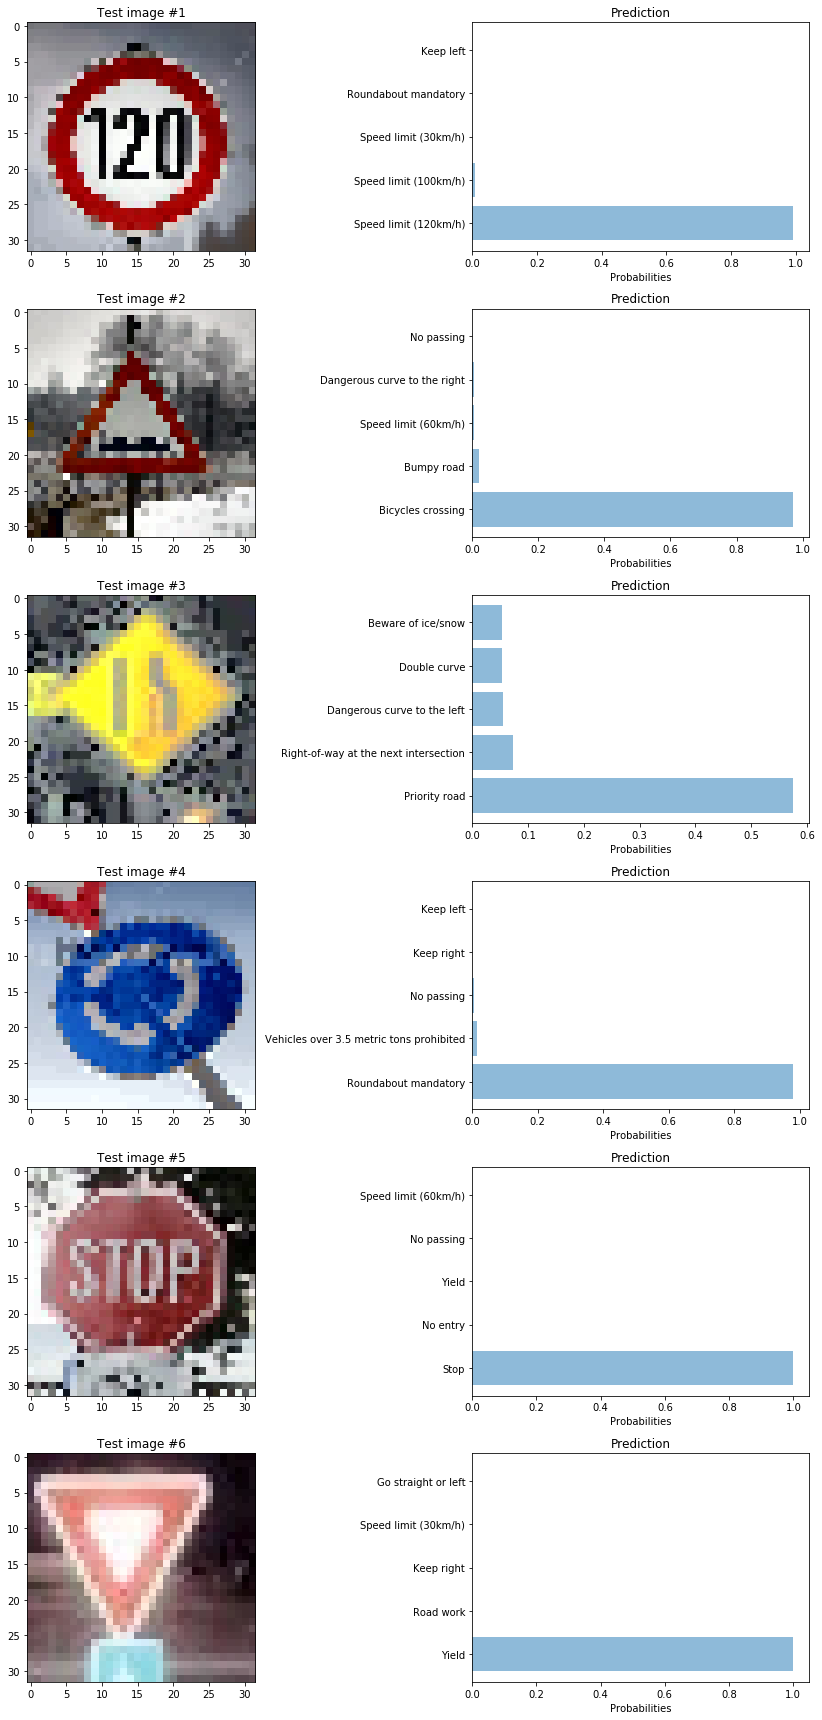

In [29]:
a, b, \
X_te, Y_te, \
c, d = load_pickled_data(None,None,'test2.p')

a, b, X_te_rgb = pre_process_data([], [], X_te, color='RGB')

train_params_RGB = {
                 'DES_ITER' : "KushNet_RGB",               #Log file for training    
                 'SAV_FILE' : "./ikushnet_RGB",            #File to save the trained model
                 'RES_TRAN' : False,                       #Resume training?
                 'RES_FILE' : "",                          #File to resume training from
                 'NUM_EPOC' : 20,                          #Number of epochs for training
                 'BAT_SIZE' : 128,                         #Batch size for training
                 'LRN_RATE' : { 'base' : 1e-3},            #Base learning rate
                 'KEP_PROB' : 1.0,                         #Keep probability for dropout
                 'REG_BETA' : 0.5,                          #Loss parameter for weights regularization
                 'INP_DEPT' : 3                              #Input image depth
                }
pred = get_pred(X_te_rgb,train_params_RGB)
plot_top_5(X_te_rgb,pred)

The network performs alright, classifying the "bumpy" road sign incorrectly. The "merge" sign image is also classified as a priority road, which makes some sense since the two signs have the same shape and color. 